# Project 1. Machine Learning
- Title : 반도체 공정 데이터를 활용한 공정 이상 예측
- Way : 분류 모델 수행 / 공정 이상에 영향을 미치는 요소들에 대한 데이터 분석

## Data From :
    - https://archive.ics.uci.edu/ml/datasets/SECOM

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='/Users/hoon/Library/Fonts/NanumSquareRegular.ttf').get_name()
plt.rc("font", family=font_name)
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import time
import re

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # 데이터 나누기, 점검 및 훈련
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score # 평가지표
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler # Feature Scaling

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

import mglearn # 그래프

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier # decisiontree에서 파생된 분류 알고리즘들
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVR, SVC

## 1. 데이터 읽기
- columns는 날짜, 센서번호, Pass/Fail
- 결과는 Pass/Fail
- 원인은 0부터 589까지 센서들
- 이상을 의미하는 센서값을 찾는 학습을 진행할 예정

In [29]:
data = pd.read_csv("data/uci-secom.csv", encoding="euc-kr")
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [31]:
data.shape

(1567, 592)

In [32]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


### 1. 결측치 제거

In [33]:
data.isnull().sum().sum()

41951

In [34]:
# Dataframe.fillna(값, inplace = True)
data = data.replace(np.NaN, 0)

data.isnull().sum().sum()

0

### 2. 불필요한 변수 제거

In [35]:
# del data['Time']
data = data.drop(columns=['Time'], axis=1)
data.shape

(1567, 591)

In [36]:
data['Pass/Fail'].value_counts()
# -1은 Pass / 1은 Fail로 보면 될 것

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

<AxesSubplot:>

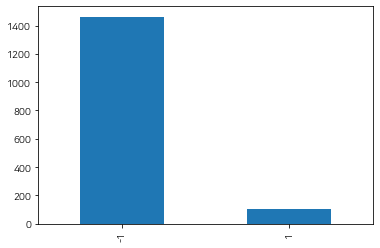

In [37]:
# 막대그래프로 표현해보기
data['Pass/Fail'].value_counts().plot(kind="bar")

In [38]:
data_345 = data.iloc[:, [3, 4, 5, -1]]
data_345

,3,4,5,Pass/Fail
0,1411.1265,1.3602,100.0,-1
1,1463.6606,0.8294,100.0,-1
2,1698.0172,1.5102,100.0,1
3,909.7926,1.3204,100.0,-1
4,1326.5200,1.5334,100.0,-1
...,...,...,...,...
1562,3085.3781,1.4843,100.0,-1
1563,1124.6595,0.8763,100.0,-1
1564,1110.4967,0.8236,100.0,-1
1565,1183.7287,1.5726,100.0,-1


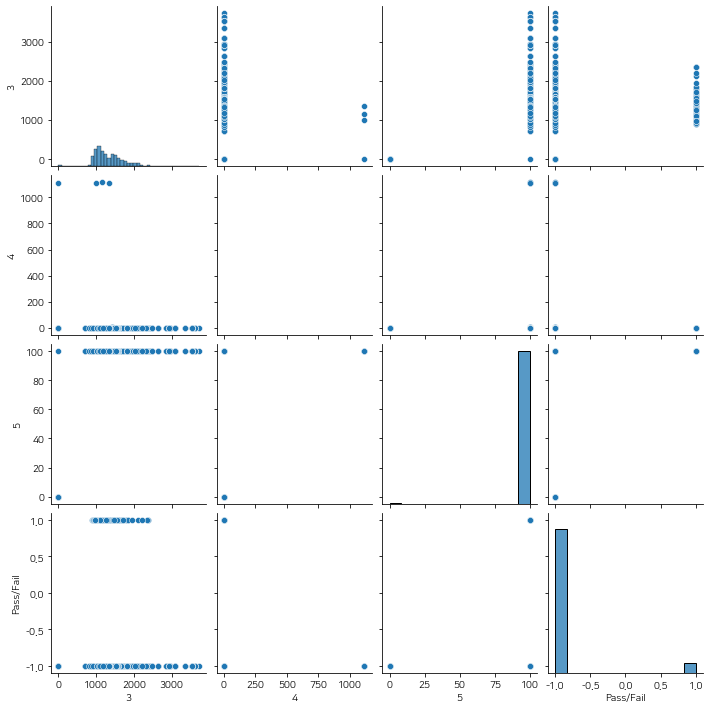

In [39]:
sns.pairplot(data_345)

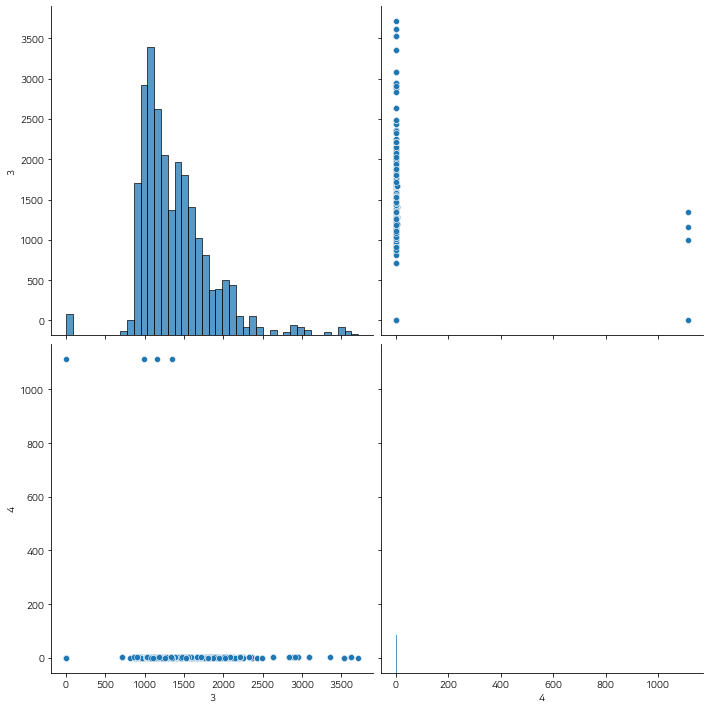

In [40]:
sns.pairplot(data_345, vars=['3', '4'], height=5)

### 3. 59번 센서 시각화

Text(0.5, 1.0, '59 Sensor Measurements')

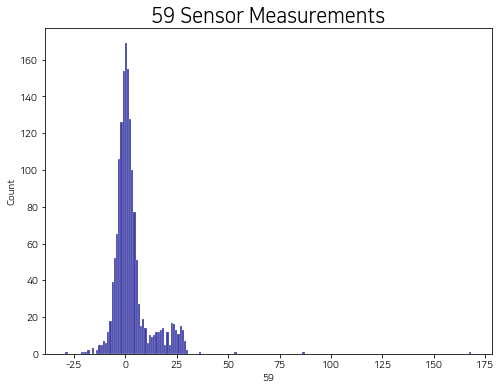

In [41]:
# 몇개의 그래프를 그릴 것인가?
# 그래프의 크기는 어떻게 할 것인가?
fig, ax = plt.subplots(figsize=(8,6))

sns.set(style="darkgrid")
sns.histplot(data['59'], color="darkblue")
plt.title("59 Sensor Measurements", fontsize=20)

Text(0.5, 1.0, '59 Sensor Measurements')

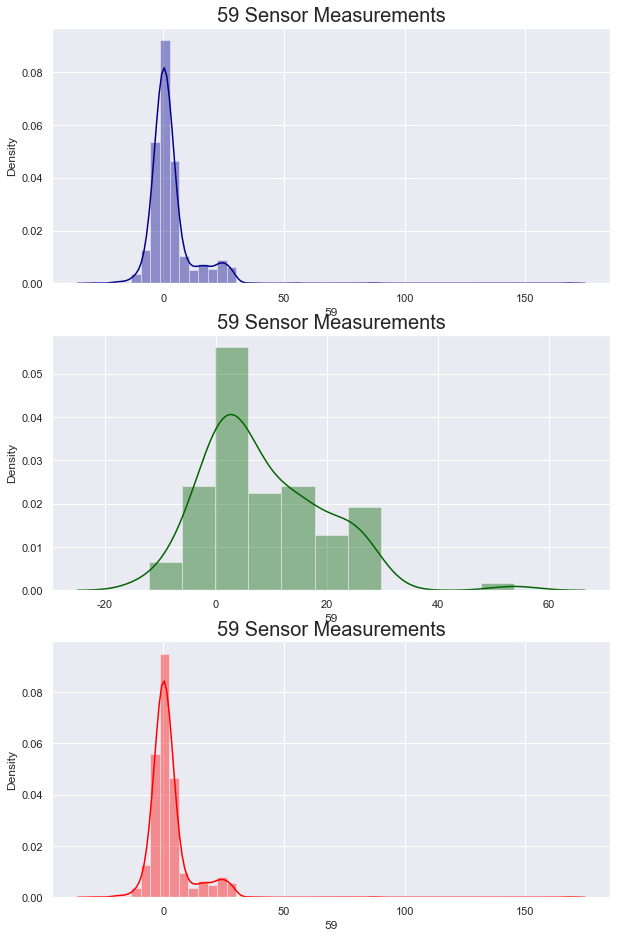

In [42]:
plt.rcParams['figure.figsize']=(10,16)

plt.subplot(3,1,1)
sns.distplot(data['59'], color="darkblue")
plt.title("59 Sensor Measurements", fontsize=20)

plt.subplot(3,1,2)
sns.distplot(data[data['Pass/Fail']==1]['59'], color="darkgreen")
plt.title("59 Sensor Measurements", fontsize=20)

plt.subplot(3,1,3)
sns.distplot(data[data['Pass/Fail']==-1]['59'], color="red")
plt.title("59 Sensor Measurements", fontsize=20)

Text(0.5, 1.0, '59 Sensor Measurements')

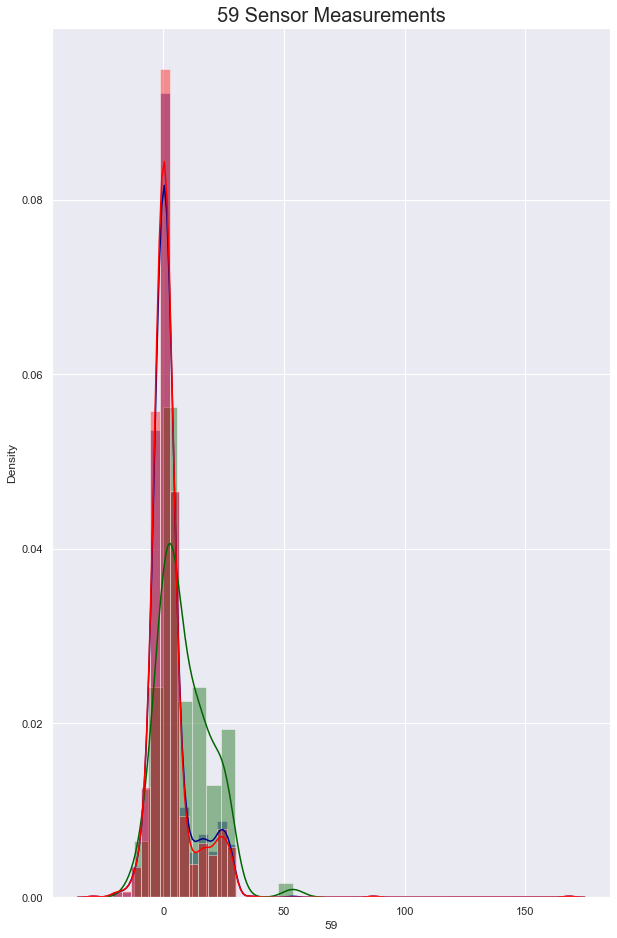

In [43]:
plt.rcParams['figure.figsize']=(10,16)

sns.distplot(data['59'], color="darkblue")
sns.distplot(data[data['Pass/Fail']==1]['59'], color="darkgreen")
sns.distplot(data[data['Pass/Fail']==-1]['59'], color="red")

plt.title("59 Sensor Measurements", fontsize=20)

In [44]:
### 산포도, 박스플랏으로 툭 튀어나오는 이상치 파악해야한다.

### 4. 데이터 전처리
- 데이터를 X, y로 분리
- Scaling

In [45]:
### X와 y로 분리
# X는 원인변수만
# y는 결과변수만

X = data.drop(columns=['Pass/Fail'], axis=1)
y = data['Pass/Fail']

In [46]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0000,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.0000,0.0000,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [47]:
y.head()

0   -1
1   -1
2    1
3   -1
4   -1
Name: Pass/Fail, dtype: int64

In [48]:
y=y.to_numpy()
y

array([-1, -1,  1, ..., -1, -1, -1])

In [49]:
data_test = pd.read_csv("data/uci-secom-test.csv", encoding='euc-kr')
data_test

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3058.576438,2456.188003,2174.584701,1113.987638,1.017292,100.0,103.784665,0.124100,1.373089,0.008796,...,53.973861,0.502555,0.012549,0.003425,2.494222,0.021644,0.017824,0.005433,98.028276,1
1,3225.540000,2500.380000,2211.400000,1511.784200,1.300400,100.0,97.470000,0.123700,1.367100,-0.019700,...,0.000000,0.498500,0.031600,0.006600,6.343200,-0.004700,0.013400,0.003500,286.130300,-1
2,3027.019797,2495.244836,2239.283771,1878.339266,1.875838,100.0,95.120185,0.122412,1.390140,0.006793,...,0.000000,0.501425,0.013365,0.003555,2.673789,0.031982,0.013443,0.004191,40.419061,-1
3,3021.865769,2415.728398,2182.942505,1101.940802,1.387535,100.0,103.816952,0.123432,1.513284,-0.027191,...,3.060171,0.496957,0.013008,0.003423,2.617648,0.034111,0.024022,0.009235,70.072016,1
4,2998.755593,2411.935120,2208.165877,1172.869419,1.364676,100.0,101.940758,0.120709,1.449954,-0.002415,...,0.000000,0.502647,0.012165,0.003780,2.415892,0.021732,0.012311,0.004373,56.939737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,3195.313583,2574.575891,2182.627068,1298.120763,1.136111,100.0,100.595296,0.123883,1.453430,-0.006297,...,0.000000,0.504501,0.010725,0.002897,2.130713,0.023792,0.018378,0.004805,78.594099,1
596,3188.528676,2487.406049,2229.243491,1919.534712,1.721749,100.0,90.751196,0.121213,1.508781,-0.000400,...,39.058868,0.503270,0.014522,0.003933,2.885034,0.027042,0.016736,0.005161,61.086557,1
597,2984.033064,2443.702629,2158.885138,1136.388716,0.969641,100.0,100.382653,0.123852,1.457508,0.011576,...,59.349219,0.506682,0.023895,0.005502,4.713328,0.026378,0.014914,0.004260,66.961602,1
598,3063.078522,2467.486566,2202.678342,1584.689479,1.277982,100.0,99.019675,0.121936,1.480350,-0.016639,...,36.450388,0.497065,0.012103,0.002981,2.427864,0.029651,0.011548,0.003842,38.986213,-1


In [50]:
X_test = data_test.drop(columns=['Pass/Fail'], axis=1)
y_test = data_test['Pass/Fail'].to_numpy()

In [51]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3058.576438,2456.188003,2174.584701,1113.987638,1.017292,100.0,103.784665,0.124100,1.373089,0.008796,...,0.004038,53.973861,0.502555,0.012549,0.003425,2.494222,0.021644,0.017824,0.005433,98.028276
1,3225.540000,2500.380000,2211.400000,1511.784200,1.300400,100.0,97.470000,0.123700,1.367100,-0.019700,...,0.000000,0.000000,0.498500,0.031600,0.006600,6.343200,-0.004700,0.013400,0.003500,286.130300
2,3027.019797,2495.244836,2239.283771,1878.339266,1.875838,100.0,95.120185,0.122412,1.390140,0.006793,...,0.000000,0.000000,0.501425,0.013365,0.003555,2.673789,0.031982,0.013443,0.004191,40.419061
3,3021.865769,2415.728398,2182.942505,1101.940802,1.387535,100.0,103.816952,0.123432,1.513284,-0.027191,...,0.000287,3.060171,0.496957,0.013008,0.003423,2.617648,0.034111,0.024022,0.009235,70.072016
4,2998.755593,2411.935120,2208.165877,1172.869419,1.364676,100.0,101.940758,0.120709,1.449954,-0.002415,...,0.000000,0.000000,0.502647,0.012165,0.003780,2.415892,0.021732,0.012311,0.004373,56.939737


In [52]:
y_test

array([ 1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
        1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1,
        1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,
        1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,
        1, -1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,
        1, -1,  1, -1, -1

### 5. 데이터 표준화

In [53]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X)
X_test = sc.transform(X_test)
y_train = y

In [54]:
print(X_train.mean())
print(X_train.var())

1.921362031951641e-17
0.8101694915254235


### 6. 머신러닝 모델 학습

#### 1. 로지스틱 회귀

In [55]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

### 0.973 // 0.845 과적합

0.9738353541799617
0.845


In [56]:
?LogisticRegression
# main parameter : penalty // c // max_iter

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [57]:
# 가장 중요한 변수는 무엇인가?
# 가장 영향력 있는 변수 확인하기
# 결국 가중치를 뽑는 것

abs_coef = np.abs(model.coef_)
abs_coef


array([[1.96666576e-02, 1.55762394e-01, 2.29984849e-01, 2.39629686e-01,
        3.20417924e-02, 4.46633622e-01, 1.24371550e-01, 4.99564405e-01,
        1.51339545e-01, 3.26916582e-01, 1.82658613e-01, 3.35668453e-02,
        2.09867827e-01, 0.00000000e+00, 5.07614998e-01, 2.70103782e-01,
        5.76722170e-01, 2.80714706e-01, 3.48493082e-01, 1.46551521e-01,
        2.63982790e-01, 5.32778315e-01, 1.51690871e-02, 1.55645189e-01,
        2.19303642e-01, 9.30188514e-01, 5.00518523e-01, 5.96497602e-02,
        1.27436678e-01, 9.00014607e-01, 6.57582104e-01, 7.48481933e-02,
        2.56419486e-01, 4.32767273e-01, 3.14493865e-02, 4.05769649e-01,
        1.99476418e-01, 9.98479336e-02, 1.11878390e-01, 2.00411981e-01,
        4.39555850e-01, 1.75630310e-01, 2.39527047e-04, 1.88379326e-01,
        1.88932240e-02, 5.38530779e-01, 2.55573059e-01, 2.44589679e-01,
        3.85268437e-01, 2.39527047e-04, 2.45879122e-01, 2.00970947e-01,
        0.00000000e+00, 4.37536586e-01, 6.24819244e-01, 2.747362

In [58]:
# 그래프로 그려야!
# 1차원으로 바꿔줘야해
# reshape, ravel()
# 고차원에서 저차원으로 바꾸는 것이니 ravel()이 편하다

abs_coef = abs_coef.ravel()
abs_coef

array([1.96666576e-02, 1.55762394e-01, 2.29984849e-01, 2.39629686e-01,
       3.20417924e-02, 4.46633622e-01, 1.24371550e-01, 4.99564405e-01,
       1.51339545e-01, 3.26916582e-01, 1.82658613e-01, 3.35668453e-02,
       2.09867827e-01, 0.00000000e+00, 5.07614998e-01, 2.70103782e-01,
       5.76722170e-01, 2.80714706e-01, 3.48493082e-01, 1.46551521e-01,
       2.63982790e-01, 5.32778315e-01, 1.51690871e-02, 1.55645189e-01,
       2.19303642e-01, 9.30188514e-01, 5.00518523e-01, 5.96497602e-02,
       1.27436678e-01, 9.00014607e-01, 6.57582104e-01, 7.48481933e-02,
       2.56419486e-01, 4.32767273e-01, 3.14493865e-02, 4.05769649e-01,
       1.99476418e-01, 9.98479336e-02, 1.11878390e-01, 2.00411981e-01,
       4.39555850e-01, 1.75630310e-01, 2.39527047e-04, 1.88379326e-01,
       1.88932240e-02, 5.38530779e-01, 2.55573059e-01, 2.44589679e-01,
       3.85268437e-01, 2.39527047e-04, 2.45879122e-01, 2.00970947e-01,
       0.00000000e+00, 4.37536586e-01, 6.24819244e-01, 2.74736229e-01,
      

Text(0, 0.5, 'Weight absolute values')

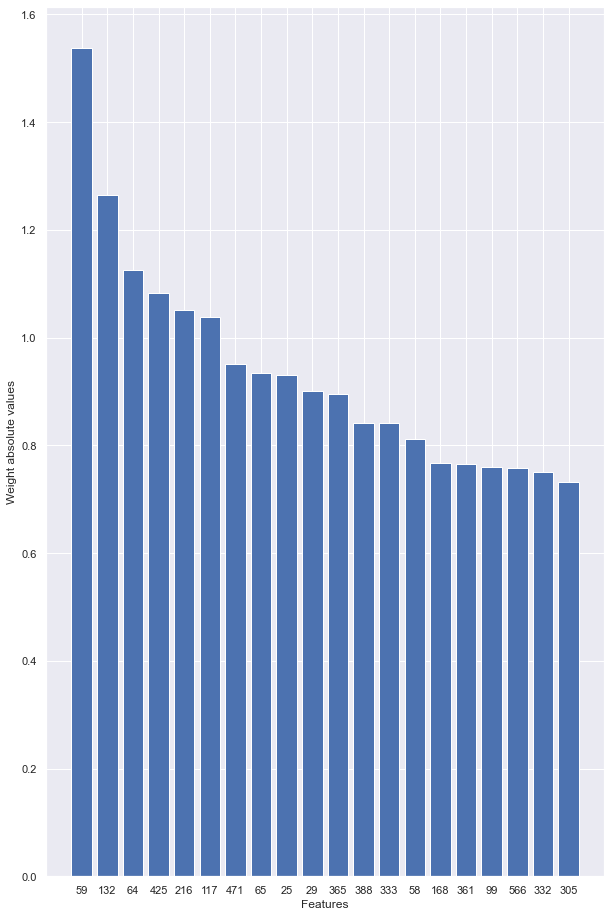

In [59]:
#enumerate는 인덱스값을 가져오는 명령어
lr_import_x = [str(i[0]) for i in sorted(enumerate(abs_coef), key=lambda x:x[1], reverse=True)]
lr_import_x


plt.bar(lr_import_x[:20], sorted(abs_coef, reverse=True)[:20])
plt.xlabel("Features")
plt.ylabel("Weight absolute values")

In [60]:
# 정렬된 기준, 즉 30번째로 중요한 센서의 가중치를 알고싶다면?
# sorted는 원래는 내림차순이다. 중요도는 오름차순이므로 reverse를 True로 해준다.
sorted(abs_coef, reverse=True)[30]

0.6551170909481144

#### 다양한 분류 모델 학습

In [61]:
### LDA -> 불필요한 칼럼은 필터링 -> 차원축소와 함께 머신러닝 진행. 지도방식
### PCA -> 차원축소 머신러닝이나 비지도 방식이다.

In [62]:
models = []
models.append(("KNN", KNeighborsClassifier()))
models.append(("NB", GaussianNB()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("SVM", SVC(gamma='auto')))
models.append(("XGB", XGBClassifier()))

In [63]:
for name, model in models:
    model.fit(X_train, y_train)

    msg = "{} - train score : {}, test score : {}".format(name, model.score(X_train, y_train), model.score(X_test, y_test))
    print(msg)

KNN - train score : 0.9342693044033185, test score : 0.5483333333333333
NB - train score : 0.18123803446075304, test score : 0.57
CART - train score : 1.0, test score : 0.66
RF - train score : 1.0, test score : 0.5016666666666667
LDA - train score : 0.9719208679004467, test score : 0.8833333333333333
SVM - train score : 0.9380982769623485, test score : 0.48833333333333334
[09:38:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB - train score : 1.0, test score : 0.6883333333333334


### 7. 평가 및 예측

#### 1. confusion matrix
- 정밀도와 재현율
- 맞춰야했는데 틀린 것은 무엇인지
- 틀렸는데 맞춰야한 것은 무엇인지

In [64]:
model_prediction_train = models[4][1].predict(X_train)

cm_train = confusion_matrix(y_train, model_prediction_train)
cm_train

array([[1448,   15],
       [  29,   75]])

[Text(0, 0.5, '-1'), Text(0, 1.5, '1')]

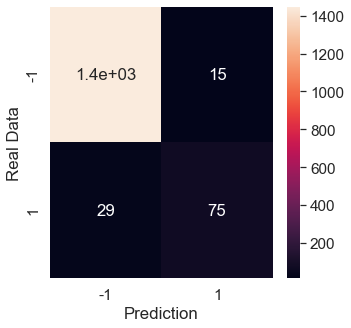

In [65]:
plt.rcParams["figure.figsize"] = (5,5)
sns.set(style="dark", font_scale=1.4)

ax = sns.heatmap(cm_train, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Real Data")
ax.set_xticklabels((-1, 1))
ax.set_yticklabels((-1, 1))

In [66]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print("재현율 : ", recall_score(y_test, models[4][1].predict(X_test)))
print("정밀도 : ", precision_score(y_test, models[4][1].predict(X_test)))

# 정밀도 측으로 너무 기울었다 :(

재현율 :  0.7795527156549521
정밀도 :  0.9959183673469387


In [70]:
for i in range(10):
    prediction = models[4][1].predict(X_test[i].reshape(1, -1))
    print("실제 데이터 : {}, 예측 데이터 : {}".format(y_test[i], prediction[0]))
#reshape(1, -1)을 한 이유는 2차원 배열로 받길 기대하고 있단 에러가 뜨기 때문

실제 데이터 : 1, 예측 데이터 : 1
실제 데이터 : -1, 예측 데이터 : 1
실제 데이터 : -1, 예측 데이터 : -1
실제 데이터 : 1, 예측 데이터 : -1
실제 데이터 : 1, 예측 데이터 : 1
실제 데이터 : -1, 예측 데이터 : -1
실제 데이터 : -1, 예측 데이터 : -1
실제 데이터 : 1, 예측 데이터 : 1
실제 데이터 : 1, 예측 데이터 : 1
실제 데이터 : 1, 예측 데이터 : 1
